In [36]:
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from limix_core.util.preprocess import gaussianize, regressOut
import scipy.stats as st

from sklearn.impute import SimpleImputer
import scipy.linalg as la
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from os.path import join
from mtgwas import VCTEST
from mtgwas.utils import df_match

In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
tissue = 'Organoid'
outdir = f'visualization/{tissue}'
os.makedirs(outdir, exist_ok=True)

In [38]:
#Reading the anndata
hfile = f"../../organoid_anndata.h5ad"
idata = ad.read_h5ad(hfile)

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
idata.obs_names = idata.obs["SampleBarcode"]

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/anndata.py:812: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['AS0033-02-MMR-001', 'AS0033-02-MMR-001', 'AS0051-03-MCS-001', 'AS0051-03-MCS-001', 'AS0009-03-MCS-007']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


In [106]:
bool_series = idata.obs['Day'] == 30

In [107]:
idata.var

,Category,Formula,Package_Library,Explanation,performed_by_channel
Feature Name,,,,,
MinDiameter_shape,Shape,"min(bbox[2]-bbox[0],bbox[3]-bbox[1])",skimage.measure.regionprops().bbox,Shortest diameter from center point of segment...,Yes
MaxDiameter_shape,Shape,"max(bbox[2]-bbox[0],bbox[3]-bbox[1])",skimage.measure.regionprops().bbox,Longest diameter from center point of segmente...,Yes
MeanDiameter_shape,Shape,"mean(bbox[2]-bbox[0],bbox[3]-bbox[1])",skimage.measure.regionprops().bbox,Mean diameter from center point of segmented o...,Yes
Area_shape,Shape,sum(foreground_mask),NaN,Area of segmented object,Yes
Perimeter_shape,Shape,sum(foreground_mask-erode(foreground_mask),NaN,Perimeter of segmented object,Yes
...,...,...,...,...,...
Solidity_halo,Shape,sum(foreround_mask) / foreground_mask.convex_area,skimage.measure.regionprops().convex_area,Ratio of the area to the area of its convex hu...,NaN
Extent_halo,Shape,sum(foreround_mask)/ROI^2,NaN,"Ratio between segmented area and total area. ""...",NaN
Eccentricity_halo,Shape,focal_distance/Major_axis,skimage.measure.regionprops().eccentricity,measure of how elongated or stretched out the ...,NaN


In [108]:
day15 = ad.AnnData(X = idata.X[bool_series], obs = idata.obs[bool_series], var = idata.var)

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [109]:
day15.obs_names

CategoricalIndex([nan, nan, nan, nan, 'AS0009-03-MCS-003', 'AS0009-03-MCS-003',
                  'AS0051-03-MCS-005', 'AS0051-03-MCS-005',
                  'AS0033-03-MCS-004', 'AS0033-03-MCS-004',
                  ...
                  nan, 'AS0009-03-MCS-004', 'AS0033-03-MCS-009',
                  'AS0051-03-MCS-009', 'AS0051-03-MCS-009',
                  'AS0051-03-MCS-006', 'AS0051-03-MCS-006',
                  'AS0009-03-MCS-009', 'AS0009-03-MCS-009',
                  'AS0051-03-MCS-008'],
                 categories=['AS0009-02-MCS-001', 'AS0009-02-MCS-002', 'AS0009-02-MCS-003', 'AS0009-02-MCS-004', ..., 'AS0051-03-MCS-007', 'AS0051-03-MCS-008', 'AS0051-03-MCS-009', 'AS0051-03-MCS-010'], ordered=False, dtype='category', name='SampleBarcode', length=1508)

In [110]:
dfX = day15.to_df()


In [111]:
dfX

Feature Name,MinDiameter_shape,MaxDiameter_shape,MeanDiameter_shape,Area_shape,Perimeter_shape,MinDiameter_um_shape,MaxDiameter_um_shape,MeanDiameter_um_shape,Area_um^2_shape,Perimeter_um_shape,...,MinDiameter_um_halo,MaxDiameter_um_halo,MeanDiameter_um_halo,Perimeter_um_halo,FormFactor_halo,Solidity_halo,Extent_halo,Eccentricity_halo,Orientation_halo,Compactness_halo
SampleBarcode,,,,,,,,,,,,,,,,,,,,,
NaN,0.641138,0.584167,0.743265,0.754376,0.327690,0.641138,0.584167,0.743265,0.754376,0.327690,...,0.243492,0.910130,0.321246,-0.519405,0.225951,0.239013,-0.196140,0.928238,0.599467,-0.107340
NaN,0.701267,0.706451,0.915505,0.986162,0.349572,0.701267,0.706452,0.915505,0.986162,0.349572,...,0.118753,-0.168735,0.271502,-0.403026,-0.072688,-0.270889,-0.103201,0.700991,0.768175,-0.078274
NaN,-1.230402,-0.408499,-1.176533,-1.241554,0.129385,-1.230402,-0.408499,-1.176533,-1.241554,0.129385,...,0.350409,-0.510375,0.331087,-0.732083,0.088901,-0.662291,-0.415125,1.616428,0.650875,-0.047072
NaN,0.385586,0.469075,0.133795,0.003901,0.620499,0.385586,0.469075,0.133795,0.003901,0.620499,...,0.510787,-0.150754,0.343056,-0.934062,0.302999,-0.734182,-0.729727,-0.302316,0.633751,-0.040661
AS0009-03-MCS-003,-2.049671,-2.106102,-2.013877,-1.774345,-1.760664,-2.049671,-2.106102,-2.013877,-1.774345,-1.760664,...,0.742444,-0.258641,0.254836,0.295447,-0.471558,-0.161123,0.224924,0.875855,0.707470,-0.091525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS0051-03-MCS-006,-1.004916,-1.264494,-1.171654,-1.237848,-0.734649,-1.004915,-1.264494,-1.171654,-1.237848,-0.734649,...,0.831543,0.226849,-0.186518,1.521312,-0.860280,-0.313382,-0.068045,-1.459122,-0.358469,-0.098791
AS0051-03-MCS-006,-1.358178,-1.595383,-1.357579,-1.374134,-1.250048,-1.358178,-1.595383,-1.357579,-1.374134,-1.250048,...,0.421689,-0.240660,0.457479,0.063906,-0.331362,-0.223952,0.289156,0.460913,0.657259,-0.092380
AS0009-03-MCS-009,0.994400,1.382615,1.368672,1.637462,0.903516,0.994400,1.382615,1.368672,1.637462,0.903516,...,-0.415839,-1.229619,0.366556,-1.761708,2.389606,-0.492131,-0.068353,-1.904519,-0.697392,-0.037241


In [112]:
dfX = dfX.groupby(["SampleBarcode"]).mean()
dfX = dfX.dropna()

/var/folders/mr/zvvy4g790mz914r9cm23_92rl3zggr/T/ipykernel_54964/3369822987.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfX = dfX.groupby(["SampleBarcode"]).mean()


In [126]:
dfX.columns

Index(['MinDiameter_shape', 'MaxDiameter_shape', 'MeanDiameter_shape',
       'Area_shape', 'Perimeter_shape', 'MinDiameter_um_shape',
       'MaxDiameter_um_shape', 'MeanDiameter_um_shape', 'Area_um^2_shape',
       'Perimeter_um_shape',
       ...
       'MinDiameter_um_halo', 'MaxDiameter_um_halo', 'MeanDiameter_um_halo',
       'Perimeter_um_halo', 'FormFactor_halo', 'Solidity_halo', 'Extent_halo',
       'Eccentricity_halo', 'Orientation_halo', 'Compactness_halo'],
      dtype='object', name='Feature Name', length=171)

In [127]:
# Simulate a trait to visualize its direction
# snp_df = pd.DataFrame(np.random.rand(dfX.shape[0], 1))
# snp_df.index = dfX.index
trait = "Area_um^2_shape"
snp_df = pd.DataFrame(np.asarray(dfX[trait]))
snp_df.index = dfX.index


In [128]:
X = dfX.values
y = snp_df.values
F = np.zeros((dfX.shape[0], 1))

In [129]:
#regressing out the covariates from the embeddings
yr = regressOut(y, F)
Xr = regressOut(X, F)

In [130]:
Xr

array([[ 0.35411185,  0.47581849,  0.45674825, ...,  0.45301998,
         0.29079989, -0.06697436],
       [ 0.75338   ,  0.72611302,  0.82371879, ..., -0.27066585,
        -0.12132768, -0.06927001],
       [ 1.09023213,  0.9932816 ,  1.20079911, ..., -1.03065801,
         0.32547048, -0.05209451],
       ...,
       [-1.38513279, -1.23944175, -1.37391651, ...,  0.36205742,
        -0.22995441, -0.07506142],
       [-0.35929772, -0.30779415, -0.32910922, ...,  0.10448773,
        -0.193404  , -0.06683711],
       [-0.87432104, -0.88460147, -0.82394278, ...,  0.0486621 ,
        -0.10024415, -0.07381321]], shape=(54, 171))

In [131]:
# fit variant component model
vc = VCTEST()
res = vc.fit(Xr, yr)
ystar = vc.predict_loo()

100%|██████████| 100/100 [00:00<00:00, 7411.87it/s]


In [132]:
# getting direction for each of the images
day15.obs['ystar'] = vc.predict(day15.X).ravel()

# Working on PGAN for interpolation

### Note below interpolation was done on simulated trait

In [133]:
import sys

from torchvision.utils import make_grid
import json
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch
os.chdir('..')
from models.progressive_gan import ProgressiveGAN as PGAN

In [134]:
class Generator():
    
    def __init__(self, config, checkpoint, useGPU=True):
        with open(config, 'rb') as file:
            config = json.load(file)
        self.pgan = PGAN(useGPU=useGPU, storeAVG=True, **config)
        self.pgan.load(checkpoint)
        self.netG = self.pgan.netG
        self.device = self.pgan.device
        
    def forward(self, x, eps=None):
        if eps is None:
            eps = torch.randn(x.shape[0], 512)
        if type(x)==np.ndarray:
            x = torch.Tensor(x)
        if type(eps)==np.ndarray:
            eps = torch.Tensor(eps)
        x = x.to(self.device)
        eps = eps.to(self.device)
        with torch.no_grad():
            out = self.netG(eps, x).data.cpu()
            out = 0.5 * (out + 1)
            out = torch.clip(out, 0, 1)
        return out
    
def load_image_torch(path, size):
    if type(path) in [list, np.ndarray]:
        return torch.cat([load_image_torch(_, size) for _ in path])
    return pil_to_tensor(Image.open(path).resize((size, size)))[None] / 255.


def torch_imshow(x):
    pl.imshow(x.permute(1, 2, 0))

In [135]:
config = '/Users/dennyal/Desktop/repos/HistoGWAS_PGAN/PGAN/config/config_OrganoidLocal.json'
checkpoint = '/Users/dennyal/Desktop/Organoid/Organoid_s6_i736000.pt'
generator = Generator(config, checkpoint, useGPU=True)

here False
Average network found !


In [141]:
# Getting the top and the bottom embedding to be used for interpolation

outliers = 0.01
extreme = 0.05
q1, q2, Q1, Q2 = np.quantile(day15.obs['ystar'].values, [outliers, extreme, 1 - extreme, 1 - outliers])
Ih1 = np.logical_and(day15.obs['ystar'].values>Q1, day15.obs['ystar'].values<Q2)
Il1 = np.logical_and(day15.obs['ystar'].values>q1, day15.obs['ystar'].values<q2)
print(Il1)

# interpolates
emb1 = day15.X[Il1].mean(0)[None]
emb2 = day15.X[Ih1].mean(0)[None]

[False False False ... False False False]


,Day,Well,Well literal,Sample_barcode,Plate,Cell_density,Run_ID,path,SampleBarcode,edit_id,ystar
SampleBarcode,,,,,,,,,,,
AS0033-02-MCS-002,30,r03c16,C16,AS0033-02-MCS-002,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-02-MCS-002,-/-,1.986908
AS0033-02-MCS-002,30,r04c16,D16,AS0033-02-MCS-002,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-02-MCS-002,-/-,1.768388
AS0009-02-MCS-003,30,r05c16,E16,AS0009-02-MCS-003,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0009-02-MCS-003,-/-,1.645053
AS0009-02-MCS-005,30,r09c20,I20,AS0009-02-MCS-005,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0009-02-MCS-005,WT/-,2.198511
AS0033-02-MCS-004,30,r13c03,M3,AS0033-02-MCS-004,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-02-MCS-004,WT/-,1.682960
NaN,30,r14c01,N1,AS0041-01-MCS-282-EDIT0151B,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,NaN,NaN,1.881429
NaN,30,r15c04,O4,AS0041-01-MCS-452-EDIT0151B,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,NaN,NaN,1.777442
NaN,30,r16c03,P3,AS0041-01-MCS-452-EDIT0151B,101,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,NaN,NaN,1.906057
AS0033-02-MCS-002,30,r04c15,D15,AS0033-02-MCS-002,102,40k,NIHB123,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-02-MCS-002,-/-,1.675971


In [137]:
emb1

array([[-2.5508776 , -2.1385915 , -2.6773407 , -2.0368416 , -2.0371985 ,
        -2.5508776 , -2.1385915 , -2.6773407 , -2.0368419 , -2.0371985 ,
        -0.86177444, -1.5795434 , -1.8967612 ,  1.3353541 , -0.09533445,
         1.2740953 ,  2.1955752 , -2.0254278 ,  0.47757924, -2.0190895 ,
         2.040871  ,  2.0416243 ,  2.1954389 , -2.021845  , -0.16112812,
        -2.0159132 ,  2.0403206 ,  2.041182  ,  2.1945143 , -2.0190105 ,
        -0.10716733, -2.0132186 ,  2.0397027 ,  2.0406268 ,  2.1955752 ,
        -2.0254278 ,  0.47757924, -2.0190895 ,  2.040871  ,  2.0416243 ,
         2.2032666 , -2.0479443 , -0.2665467 , -2.038006  ,  2.045922  ,
         2.0464585 ,  2.2024124 , -2.0428655 , -1.1916282 , -2.0340517 ,
         2.0444932 ,  2.0451112 ,  2.2021172 , -2.041821  , -1.2515244 ,
        -2.0331333 ,  2.0442178 ,  2.0448122 ,  2.2032666 , -2.0479443 ,
        -0.2665467 , -2.038006  ,  2.045922  ,  2.0464585 ,  2.2108529 ,
        -2.0641794 , -0.8589573 , -2.0508997 ,  2.0

In [138]:
emb1.shape

(1, 171)

In [139]:
os.chdir("/Users/dennyal/Desktop/repos/HistoGWAS_PGAN/PGAN/Notebooks")
for i in range(1):   # This are different realization of the same embedding
    inter = np.linspace(0, 1, 8)[:, None]
    Embs = emb1 * (1 - inter) + emb2 * inter
    print(np.ones([Embs.shape[0], 1]).shape)
    Eps = np.random.randn(1, 512) * np.ones([Embs.shape[0], 1])
    print(Eps.shape)
    Xinter = generator.forward(Embs, Eps)
    print("here",Xinter.shape)
    
    outdir_temp = join(outdir, f'realization_{i}')
    os.makedirs(outdir_temp, exist_ok=True)
    images = []
    for idx,img in enumerate(Xinter):
        print(idx)
        print(img.shape)
        img = to_pil_image(img)
        outfile = join(outdir_temp, f'{idx}_{tissue}.PNG')
        
        images.append(img)
    images_forward = images
    images_backward = images[::-1]  # Reverse the order of frames

    looped_frames = images_forward + images_backward[1:]
    
    
    os.makedirs(outdir, exist_ok=True)
    gif_file = f"{tissue}_interpolation_Day15__{trait}{i}.gif"
    outfile = join(outdir, gif_file)
    looped_frames[0].save(outfile, save_all=True, append_images=looped_frames[1:], loop=0)

  
    
Xinter_grid = make_grid(Xinter, nrow=8)

(8, 1)
(8, 512)
here torch.Size([8, 1, 256, 256])
0
torch.Size([1, 256, 256])
1
torch.Size([1, 256, 256])
2
torch.Size([1, 256, 256])
3
torch.Size([1, 256, 256])
4
torch.Size([1, 256, 256])
5
torch.Size([1, 256, 256])
6
torch.Size([1, 256, 256])
7
torch.Size([1, 256, 256])


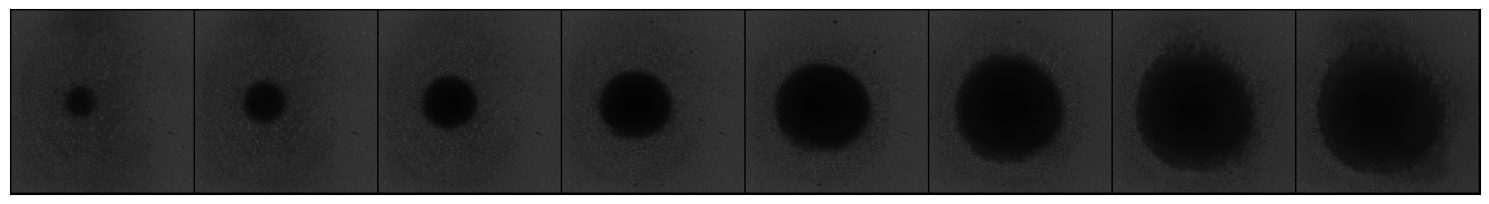

In [140]:
# Doing the projection
pl.figure(1, figsize=(15, 15))
plt = pl.subplot(111)
torch_imshow(Xinter_grid)
plt.set_xticks([])
plt.set_yticks([])
pl.tight_layout()
#pl.savefig(f'{figdir}/randomsamples.png', dpi=300)